In [5]:

import os
import cv2
import csv
import pickle
import numpy as np
import itertools
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern

## Useful Functions

In [6]:
def read_images(path):
    images = []
    labels = []
    num1 = 32
    num2 = 32
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = cv2.imread(file_path + '/' + img_name)
                    new_img = cv2.resize(img, (num2, num1))
                    images.append(new_img)
                    if file_name == 'Parasite':
                        label = 0
                    elif file_name == 'Uninfected':
                        label = 1
                    labels.append(label)
    
    return np.array(images), np.array(labels)

In [7]:
def write_csv(file, a1, a2, a3, a4, a5, a6, a7, name):
    with open(file, mode='w') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(name)
        for i in range(20):
            if a2[i] == None:
                a2[i] = 'None'
            if a4[i] == None:
                a4[i] = 'None'
            csv_writer.writerow([a1[i], a2[i], a3[i], a4[i], a5[i], a6[i], a7[i]])

## Save, Load 

In [8]:
def save_feature(feature, name):
    # saving all our feature vectors in pickled file
    with open('cache/' + name + '.pkl', 'wb') as fp:
        pickle.dump(csr_matrix(feature), fp)
    
    print(f'Feature saved with name cache/{name}.pkl')

def load_feature(feature_name):
    return pickle.load(open(feature_name, 'rb')).A

In [9]:
def save_model(model):
    filename = input('Enter model file name:')
    pickle.dump(model, open('models/'+filename + '.pkl', 'wb'))
    print(f'Successfully saved model in models/{filename}.pkl')

def load_model(model_name):
    return pickle.load(open(model_name, 'rb'))

In [10]:
def flatten(images, color=cv2.COLOR_RGB2GRAY, name='flattened', save=False):
    """
    color: default RGB2GRAY, if None is passed then color is used as it is.
    """
    color_images = []
    if color is not None:
        for img in images:
            color_images.append(cv2.cvtColor(img, color))
    else:
        color_images = images
    
    count = len(color_images)
    
    result = np.array(color_images).reshape(count, -1)
    
    if save:
        save_feature(result, name)
        
    return result

## Feature Extraction

In [11]:
def color_histogram(images, name='color_hist', save=False):
    histograms = []
    for img in images:
        histograms.append(cv2.calcHist([img], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten())
    
    result = np.array(histograms)
    
    if save:
        save_feature(result, name)
        
    return result

In [33]:
def surf(images, name='surf', save=False):
    # SURF descriptor for 1 image
    def get_image_surf(image, vector_size=4):
        alg = cv2.xfeatures2d.SURF_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SURF descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_surf(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [13]:
def surf_kp(image):
    alg = cv2.xfeatures2d.SURF_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:4]

    # Making descriptor of same size
    # Descriptor vector size is 64
    needed_size = (15 * 64)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

In [14]:
def get_hog(images, name='hog', save=False):
    result = np.array([hog(img, block_norm='L2') for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

In [15]:
def kaze(images, name='kaze', save=False):
    # KAZE descriptor for 1 image
    def get_image_kaze(image, vector_size=32):
        alg = cv2.KAZE_create()
        kps = alg.detect(image)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        
        if dsc.size < needed_size:
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
        return dsc
    
    # KAZE descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_kaze(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [34]:
def sift(images, name='sift', save=False):
    # SIFT descriptor for 1 image
    def get_image_sift(image, vector_size=15):
        alg = cv2.xfeatures2d.SIFT_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 128
        needed_size = (vector_size * 128)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SIFT descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_sift(img)
        features.append(dsc)

    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [17]:
def sift_kp(image):
    alg = cv2.xfeatures2d.SIFT_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:15]

    # Making descriptor of same size
    # Descriptor vector size is 128
    needed_size = (15 * 128)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

In [18]:
def lbp(images, name='lbp', save=False):
    result = np.array([local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 10, 3).flatten() for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

In [19]:
def combine_features(features, horizontal=True):
    """
    Array of features [f1, f2, f3] where each fi is a feature set 
    eg. f1=rgb_flat, f2=SIFT, etc.
    """
    if horizontal:
        return np.hstack(features)
    else:
        return np.vstack(features)


def norm_features_min_max(train, test):
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test


def norm_features_zscore(train, test):
    min_max_scaler = preprocessing.StandardScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

In [20]:
def train_model(train_x, train_y, validation=None):
    """
    
    validation: (val_x, val_y) tupple for validation accuracy score.
    
    return: trained model
    """

    model = GaussianNB()
    model_name = 'Naive Bayes'
    model.fit(train_x, train_y)
    
    if validation is not None:
        y_hat = model.predict(validation[0])
        acc = metrics.accuracy_score(validation[1], y_hat)
        print(f"Validation Accuracy in '{model_name}' = {acc}")
        cm = metrics.confusion_matrix(validation[1], y_hat)
        print(cm)
        recall = cm[0][0] / (cm[0][0] + cm[0][1])
        precision = cm[0][0] / (cm[0][0] + cm[1][0])
        f1 = 2*(precision*recall)/(precision+recall)
        print(f"Recall in '{model_name}' = {recall}")
        print(f"Precision in '{model_name}' = {precision}")
        print(f"F1 Score in '{model_name}' = {f1}")
               
    return model

In [21]:
def confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):

        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.grid(False)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()

In [22]:
def pca_projection(mat, name_arr):
    plt.figure(figsize=(15,20))
    for i, img in enumerate(mat, start=1):
        plt.subplot(4, 2, i)
        y = np.var(mat[i-1], axis=0)
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '--o')
        plt.ylabel('Variance')
        plt.xlabel('Data Projected on Eigen Vector Number')
        plt.xticks(x)
        plt.title(name_arr[i-1])
    plt.savefig('output/pca/subplot.jpg')
    plt.show()

def draw_key_points(image, kp):
    img = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

In [27]:
tr_x, tr_y = read_images('Dataset/Train')
te_x, te_y = read_images('Dataset/Test')
train_imgs, val_imgs, train_y, val_y = train_test_split(tr_x, tr_y, test_size=0.2)
data_x, test_x, data_y, test_y = train_test_split(te_x, te_y, test_size=0.2)

# save
np.save('data/train_imgs.npy', train_imgs)
np.save('data/train_y.npy', train_y)
np.save('data/val_imgs.npy', val_imgs)
np.save('data/val_y.npy', val_y)

np.save('data/data_x.npy', data_x)
np.save('data/data_y.npy', data_y)
np.save('data/test_x.npy', test_x)
np.save('data/test_y.npy', test_y)


# load
train_imgs = np.load('data/train_imgs.npy')
train_y = np.load('data/train_y.npy')
val_imgs = np.load('data/val_imgs.npy')
val_y = np.load('data/val_y.npy')

data_x = np.load('data/data_x.npy')
data_y = np.load('data/data_y.npy')
test_x = np.load('data/test_x.npy')
test_y = np.load('data/test_y.npy')



In [28]:
tr_x.shape, tr_y.shape

((416, 32, 32, 3), (416,))

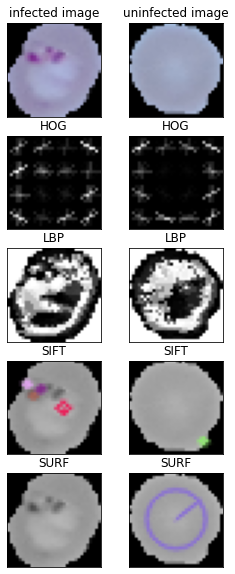

In [30]:
infected_img = train_imgs[train_y == 0][8]
uninfected_img = train_imgs[train_y == 1][4]
classes = []
classes.append(infected_img)
classes.append(uninfected_img)
class_label= []
class_label.append('infected image')
class_label.append('uninfected image')

vis_img = np.zeros((2, 32, 32))
lbp_img = np.zeros((2, 32, 32))
sift = np.zeros((2, 32, 32, 3), dtype='uint8')
surf = np.zeros((2, 32, 32, 3), dtype='uint8')

for i in range(2):
    temp1, vis_img[i] = hog(classes[i], block_norm='L2', visualize=True)
    lbp_img[i] = local_binary_pattern(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), 10, 3)
    sift[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), sift_kp(classes[i]))
    surf[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), surf_kp(classes[i]))


data_vis = []
for i in range(len(classes)):
    data_vis.append(classes[i])
for i in range(len(classes)):
    data_vis.append(vis_img[i])
for i in range(len(classes)):
    data_vis.append(lbp_img[i])
for i in range(len(classes)):
    data_vis.append(sift[i])
for i in range(len(classes)):
    data_vis.append(surf[i])

img_name_arr = []
for i in range(len(classes)):
    img_name_arr.append(class_label[i])
for i in range(len(classes)):
    img_name_arr.append('HOG')
for i in range(len(classes)):
    img_name_arr.append('LBP')
for i in range(len(classes)):
    img_name_arr.append('SIFT')
for i in range(len(classes)):
    img_name_arr.append('SURF')


plt.figure(figsize=(4,10))
for i, img in enumerate(data_vis, start=1):
    plt.subplot(5, 2, i)
    plt.title(img_name_arr[i-1])
    frame1 = plt.gca()
    for tick in frame1.axes.get_xticklines():
        tick.set_visible(False)
    for tick in frame1.axes.get_yticklines():
        tick.set_visible(False)
    for xlabel_i in frame1.axes.get_xticklabels():
        xlabel_i.set_visible(False)
    for xlabel_i in frame1.axes.get_yticklabels():
        xlabel_i.set_visible(False)
    plt.imshow(data_vis[i-1], cmap='gray')
plt.savefig('output/feature_visualization.png')
plt.show()

In [31]:
# HOG
hog_train = get_hog(train_imgs, name='hog_train', save=True)
hog_val = get_hog(val_imgs, name='hog_val', save=True)

hog_train = load_feature('cache/hog_train.pkl')
hog_val = load_feature('cache/hog_val.pkl')

# LBP
lbp_train = lbp(train_imgs, name='lbp_train', save=True)
lbp_val = lbp(val_imgs, name='lbp_val', save=True)

lbp_train = load_feature('cache/lbp_train.pkl')
lbp_val = load_feature('cache/lbp_val.pkl')

# KAZE
kaze_train = kaze(train_imgs, name='kaze_train', save=True)
kaze_val = kaze(val_imgs, name='kaze_val', save=True)

kaze_train = load_feature('cache/kaze_train.pkl')
kaze_val = load_feature('cache/kaze_val.pkl')




Feature saved with name cache/hog_train.pkl
Feature saved with name cache/hog_val.pkl
Feature saved with name cache/lbp_train.pkl
Feature saved with name cache/lbp_val.pkl
Feature saved with name cache/kaze_train.pkl
Feature saved with name cache/kaze_val.pkl


In [35]:


# SURF
surf_train = surf(train_imgs, name='surf_train', save=True)
surf_val = surf(val_imgs, name='surf_val', save=True)

surf_train = load_feature('cache/surf_train.pkl')
surf_val = load_feature('cache/surf_val.pkl')

# SIFT
sift_train = sift(train_imgs, name='sift_train', save=True)
sift_val = sift(val_imgs, name='sift_val', save=True)

sift_train = load_feature('cache/sift_train.pkl')
sift_val = load_feature('cache/sift_val.pkl')

Feature saved with name cache/surf_train.pkl
Feature saved with name cache/surf_val.pkl
Feature saved with name cache/sift_train.pkl
Feature saved with name cache/sift_val.pkl


In [36]:
# RGB
flat_rgb_train = flatten(train_imgs, None, name='flat_rgb_train', save=True)
flat_rgb_val = flatten(val_imgs, None, name='flat_rgb_val', save=True)

flat_rgb_train = load_feature('cache/flat_rgb_train.pkl')
flat_rgb_val = load_feature('cache/flat_rgb_val.pkl')

# GRAYSCALE
flat_gray_train = flatten(train_imgs, name='flat_gray_train', save=True)
flat_gray_val = flatten(val_imgs, name='flat_gray_val', save=True)

flat_gray_train = load_feature('cache/flat_gray_train.pkl')
flat_gray_val = load_feature('cache/flat_gray_val.pkl')

# Color Histogram
hist_train = color_histogram(train_imgs, name='hist_train', save=True)
hist_val = color_histogram(val_imgs, name='hist_val', save=True)

hist_train = load_feature('cache/hist_train.pkl')
hist_val = load_feature('cache/hist_val.pkl')



Feature saved with name cache/flat_rgb_train.pkl
Feature saved with name cache/flat_rgb_val.pkl
Feature saved with name cache/flat_gray_train.pkl
Feature saved with name cache/flat_gray_val.pkl
Feature saved with name cache/hist_train.pkl
Feature saved with name cache/hist_val.pkl


In [37]:
# HOG
norm_hog_train, norm_hog_val = norm_features_zscore(hog_train, hog_val)

pca = PCA(n_components=10)
pca_hog_train = pca.fit_transform(norm_hog_train)
pca_hog_val = pca.transform(norm_hog_val)

np.save('cache/pca_hog_train.npy', pca_hog_train)
np.save('cache/pca_hog_val.npy', pca_hog_val)

pca_hog_train = np.load('cache/pca_hog_train.npy')
pca_hog_val = np.load('cache/pca_hog_val.npy')

# LBP
norm_lbp_train, norm_lbp_val = norm_features_zscore(lbp_train, lbp_val)

pca = PCA(n_components=10)
pca_lbp_train = pca.fit_transform(norm_lbp_train)
pca_lbp_val = pca.transform(norm_lbp_val)

np.save('cache/pca_lbp_train.npy', pca_lbp_train)
np.save('cache/pca_lbp_val.npy', pca_lbp_val)

pca_lbp_train = np.load('cache/pca_lbp_train.npy')
pca_lbp_val = np.load('cache/pca_lbp_val.npy')

# KAZE
norm_kaze_train, norm_kaze_val = norm_features_zscore(kaze_train, kaze_val)

pca = PCA(n_components=10)
pca_kaze_train = pca.fit_transform(norm_kaze_train)
pca_kaze_val = pca.transform(norm_kaze_val)

np.save('cache/pca_kaze_train.npy', pca_kaze_train)
np.save('cache/pca_kaze_val.npy', pca_kaze_val)

pca_kaze_train = np.load('cache/pca_kaze_train.npy')
pca_kaze_val = np.load('cache/pca_kaze_val.npy')

# SIFT
norm_sift_train, norm_sift_val = norm_features_zscore(sift_train, sift_val)

pca = PCA(n_components=5)
pca_sift_train = pca.fit_transform(norm_sift_train)
pca_sift_val = pca.transform(norm_sift_val)

np.save('cache/pca_sift_train.npy', pca_sift_train)
np.save('cache/pca_sift_val.npy', pca_sift_val)

pca_sift_train = np.load('cache/pca_sift_train.npy')
pca_sift_val = np.load('cache/pca_sift_val.npy')

# SURF
norm_surf_train, norm_surf_val = norm_features_zscore(surf_train, surf_val)

pca = PCA(n_components=5)
pca_surf_train = pca.fit_transform(norm_surf_train)
pca_surf_val = pca.transform(norm_surf_val)

np.save('cache/pca_surf_train.npy', pca_surf_train)
np.save('cache/pca_surf_val.npy', pca_surf_val)

pca_surf_train = np.load('cache/pca_surf_train.npy')
pca_surf_val = np.load('cache/pca_surf_val.npy')



In [38]:
# RGB
norm_flat_rgb_train, norm_flat_rgb_val = norm_features_zscore(flat_rgb_train, flat_rgb_val)
pca = PCA(n_components=10)
pca_flat_rgb_train = pca.fit_transform(norm_flat_rgb_train)
pca_flat_rgb_val = pca.transform(norm_flat_rgb_val)
np.save('cache/pca_flat_rgb_train.npy', pca_flat_rgb_train)
np.save('cache/pca_flat_rgb_val.npy', pca_flat_rgb_val)
pca_flat_rgb_train = np.load('cache/pca_flat_rgb_train.npy')
pca_flat_rgb_val = np.load('cache/pca_flat_rgb_val.npy')

# GRAYSCALE
norm_flat_gray_train, norm_flat_gray_val = norm_features_zscore(flat_gray_train, flat_gray_val)
pca = PCA(n_components=6)
pca_flat_gray_train = pca.fit_transform(norm_flat_gray_train)
pca_flat_gray_val = pca.transform(norm_flat_gray_val)
np.save('cache/pca_flat_gray_train.npy', pca_flat_gray_train)
np.save('cache/pca_flat_gray_val.npy', pca_flat_gray_val)
pca_flat_gray_train = np.load('cache/pca_flat_gray_train.npy')
pca_flat_gray_val = np.load('cache/pca_flat_gray_val.npy')

# Color Histogram
norm_hist_train, norm_hist_val = norm_features_zscore(hist_train, hist_val)
pca = PCA(n_components=10)
pca_hist_train = pca.fit_transform(norm_hist_train)
pca_hist_val = pca.transform(norm_hist_val)
np.save('cache/pca_hist_train.npy', pca_hist_train)
np.save('cache/pca_hist_val.npy', pca_hist_val)
pca_hist_train = np.load('cache/pca_hist_train.npy')
pca_hist_val = np.load('cache/pca_hist_val.npy')



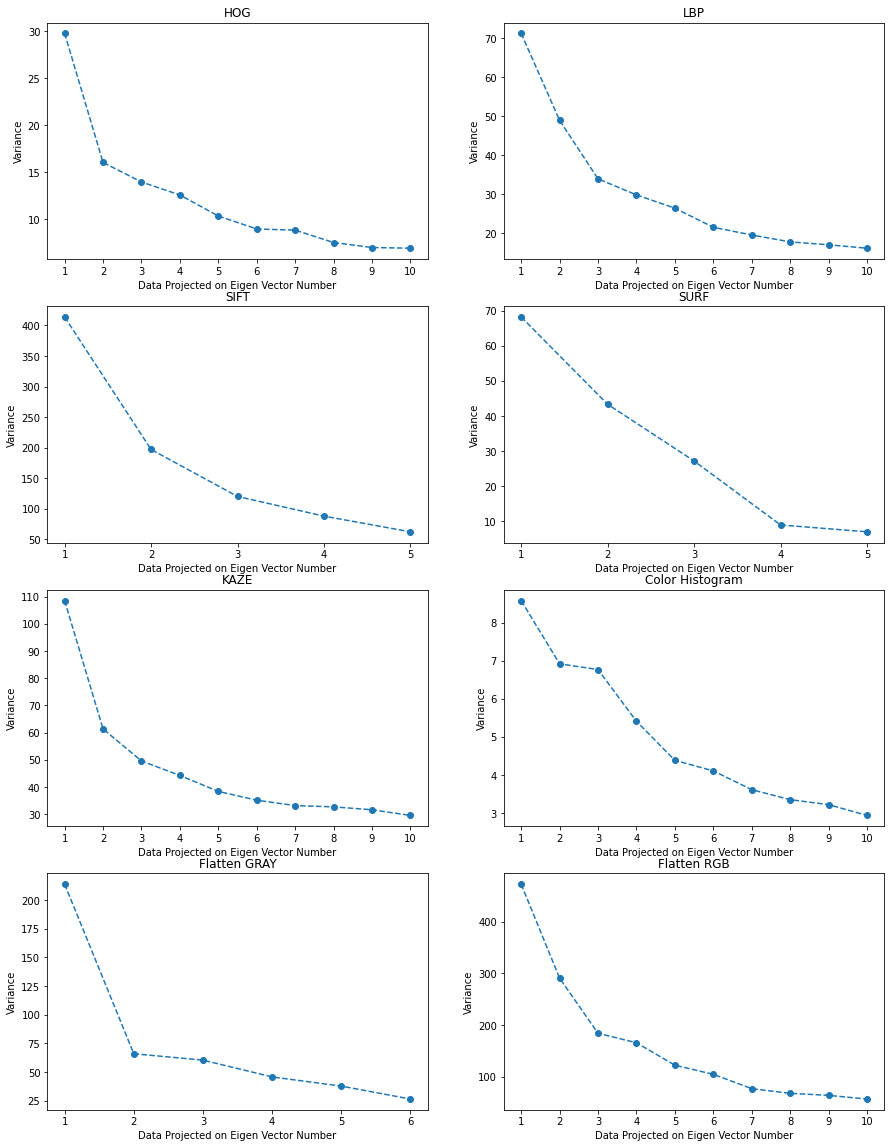

In [39]:
pca_array = []
pca_array.append(pca_hog_train)
pca_array.append(pca_lbp_train)
pca_array.append(pca_sift_train)
pca_array.append(pca_surf_train)
pca_array.append(pca_kaze_train)
pca_array.append(pca_hist_train)
pca_array.append(pca_flat_gray_train)
pca_array.append(pca_flat_rgb_train)

pca_projection(pca_array, ['HOG', 'LBP', 'SIFT', 'SURF', 'KAZE', 'Color Histogram', 'Flatten GRAY', 'Flatten RGB'])

In [40]:
# HOG Features
lda = LDA()
lda_hog_train = lda.fit_transform(norm_hog_train, train_y)
lda_hog_val = lda.transform(norm_hog_val)
np.save('cache/lda_hog_train.npy', lda_hog_train)
np.save('cache/lda_hog_val.npy', lda_hog_val)
lda_hog_train = np.load('cache/lda_hog_train.npy')
lda_hog_val = np.load('cache/lda_hog_val.npy')

# LBP Features
lda = LDA()
lda_lbp_train = lda.fit_transform(norm_lbp_train, train_y)
lda_lbp_val = lda.transform(norm_lbp_val)
np.save('cache/lda_lbp_train.npy', lda_lbp_train)
np.save('cache/lda_lbp_val.npy', lda_lbp_val)
lda_lbp_train = np.load('cache/lda_lbp_train.npy')
lda_lbp_val = np.load('cache/lda_lbp_val.npy')

# SIFT Features
lda = LDA()
lda_sift_train = lda.fit_transform(norm_sift_train, train_y)
lda_sift_val = lda.transform(norm_sift_val)
np.save('cache/lda_sift_train.npy', lda_sift_train)
np.save('cache/lda_sift_val.npy', lda_sift_val)
lda_sift_train = np.load('cache/lda_sift_train.npy')
lda_sift_val = np.load('cache/lda_sift_val.npy')

# Color Histogram
lda = LDA()
lda_hist_train = lda.fit_transform(norm_hist_train, train_y)
lda_hist_val = lda.transform(norm_hist_val)
np.save('cache/lda_hist_train.npy', lda_hist_train)
np.save('cache/lda_hist_val.npy', lda_hist_val)
lda_hist_train = np.load('cache/lda_hist_train.npy')
lda_hist_val = np.load('cache/lda_hist_val.npy')


In [41]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([hog_train, hist_train, surf_train, flat_rgb_train, lbp_train, kaze_train, sift_train], 
                  [hog_val, hist_val, surf_val, flat_rgb_val, lbp_val, kaze_val, sift_val]):    
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [42]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([pca_hog_train, pca_lbp_train, pca_sift_train, pca_flat_rgb_train, pca_hist_train], 
                  [pca_hog_val, pca_lbp_val, pca_sift_val, pca_flat_rgb_val, pca_hist_val]):    
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [43]:
features_train_lda = None
features_val_lda = None
evs = []
for ft, fv in zip([lda_hog_train, lda_hist_train, lda_lbp_train, lda_sift_train], 
                  [lda_hog_val, lda_hist_val, lda_lbp_val, lda_sift_val]):    
    if features_train_lda is None:
        features_train_lda = ft
        features_val_lda = fv
    else:
        features_train_lda = combine_features([features_train_lda, ft])
        features_val_lda = combine_features([features_val_lda, fv])

In [44]:
lda = LDA()
lda_on_pca_train = lda.fit_transform(features_train, train_y)
lda_on_pca_val = lda.transform(features_val)

np.save('cache/lda_on_pca_train.npy', lda_on_pca_train)
np.save('cache/lda_on_pca_val.npy', lda_on_pca_val)

lda_on_pca_train = np.load('cache/lda_on_pca_train.npy')
lda_on_pca_val = np.load('cache/lda_on_pca_val.npy')

features_t = pca_hist_train
features_v = pca_hist_val

In [45]:
nb_model_pca = train_model(features_train, train_y, validation=(features_val, val_y))

prob_nb = nb_model_pca.predict_proba(features_val)
prob_nb_0 = prob_nb[:,0].reshape(prob_nb.shape[0], 1)
prob_nb_1 = prob_nb[:,1].reshape(prob_nb.shape[0], 1)

Validation Accuracy in 'Naive Bayes' = 0.8452380952380952
[[33 13]
 [ 0 38]]
Recall in 'Naive Bayes' = 0.717391304347826
Precision in 'Naive Bayes' = 1.0
F1 Score in 'Naive Bayes' = 0.8354430379746834


In [57]:
def p_roc(val_y, probs):
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(val_y, preds)
  roc_auc = metrics.auc(fpr, tpr)

  # method I: plt
  import matplotlib.pyplot as plt
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()


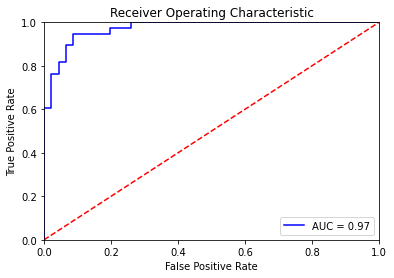

In [58]:
p_roc(val_y, prob_nb)

In [60]:
nb_model_lda = train_model(features_train_lda, train_y, validation=(features_val_lda, val_y))
prob_nb_lda = nb_model_lda.predict_proba(features_val_lda)
prob_nb_lda_0 = prob_nb_lda[:,0].reshape(prob_nb_lda.shape[0], 1)
prob_nb_lda_1 = prob_nb_lda[:,1].reshape(prob_nb_lda.shape[0], 1)


Validation Accuracy in 'Naive Bayes' = 0.6071428571428571
[[27 19]
 [14 24]]
Recall in 'Naive Bayes' = 0.5869565217391305
Precision in 'Naive Bayes' = 0.6585365853658537
F1 Score in 'Naive Bayes' = 0.6206896551724138


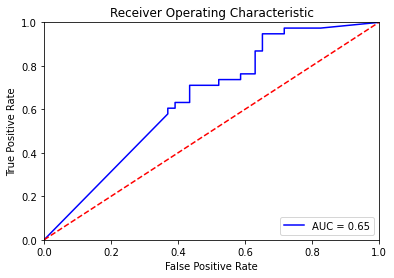

In [64]:
p_roc(val_y, prob_nb_lda)

In [65]:
nb_model_LP = train_model(lda_on_pca_train, train_y, validation=(lda_on_pca_val, val_y))
prob_LP = nb_model_LP.predict_proba(lda_on_pca_val)
prob_LP_0 = prob_LP[:,0].reshape(prob_LP.shape[0], 1)
prob_LP_1 = prob_LP[:,1].reshape(prob_LP.shape[0], 1)

Validation Accuracy in 'Naive Bayes' = 0.8928571428571429
[[38  8]
 [ 1 37]]
Recall in 'Naive Bayes' = 0.8260869565217391
Precision in 'Naive Bayes' = 0.9743589743589743
F1 Score in 'Naive Bayes' = 0.8941176470588235


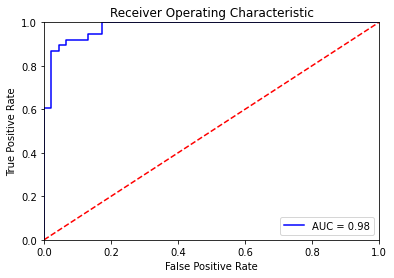

In [66]:
p_roc(val_y, prob_LP)